In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
repo_dir = '/home/labs/amit/noamsh/repos/MM_2023'
sys.path.append(repo_dir)

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import plotly.express as px
import pickle

In [4]:
data_dir_path = Path("/home/labs/amit/noamsh/data/CAR_T")

## exp results loading

In [5]:
def generate_experiment_name(use_cell_frequencies, use_mye_pathways, use_metadata_as_features):
    features_names = []
    if use_cell_frequencies:
        features_names.append('comp')
    if use_mye_pathways:
        features_names.append('mye_pathways')
    if use_metadata_as_features:
        features_names.append('metadata')
    experiment_name = '_'.join(features_names + ['results'])
    return experiment_name

def load_results_of_exp_name(exp_name, dir=data_dir_path):
    exp_results_path = Path(dir, f"{exp_name}.pkl")
    with open(exp_results_path, 'rb') as handle:
        results = pickle.load(handle)
    return results

In [6]:
comp_pathways_exp_name = generate_experiment_name(use_cell_frequencies=True, use_mye_pathways=True, use_metadata_as_features=False)

comp_pathways_results = load_results_of_exp_name(comp_pathways_exp_name)
print(comp_pathways_exp_name)
# comp_pathways_results['features'] # .keys()

comp_mye_pathways_results


In [7]:
comp_exp_name = generate_experiment_name(use_cell_frequencies=True, use_mye_pathways=False, use_metadata_as_features=False)

comp_results = load_results_of_exp_name(comp_exp_name)

print(comp_exp_name)
# comp_results['features']

comp_results


In [8]:
pathways_exp_name = generate_experiment_name(use_cell_frequencies=False, use_mye_pathways=True, use_metadata_as_features=False)

pathways_results = load_results_of_exp_name(pathways_exp_name)

print(pathways_exp_name)
comp_results.keys()

mye_pathways_results


dict_keys(['X', 'y', 'patient_map', 'features', 'loocv', 'test', 'external_eval'])

In [9]:
exps_dict = {
    "Cellular frequencies": comp_results,
    "Myeloid pathways": pathways_results,
    "Combined": comp_pathways_results
}

In [10]:
# comp_results['patient_map'].set_index("patient")["sample_name"]
# comp_results['loocv']['y_pred']

## plot per experiment visualization

In [11]:
from evaluation.visualizations import plot_ROC_PRauc_CM_stem

In [12]:
def print_metrics(y_true, y_score):
    report = metrics.classification_report(y_true, y_score, output_dict=True)
    print_report = {
        "R precision": round(report['1']['precision'], 3),
        "NR precision": round(report['0']['precision'], 3),
        'accuracy': round(report['accuracy'],3)
    }
    print_repors_list = [f"{k}: {v}" for k,v in print_report.items()]
    print("\n".join(print_repors_list))

In [13]:
patient_name_map = comp_results['patient_map'].set_index("patient")["sample_name"]

Cellular frequencies: loocv
R precision: 0.789
NR precision: 0.409
accuracy: 0.585


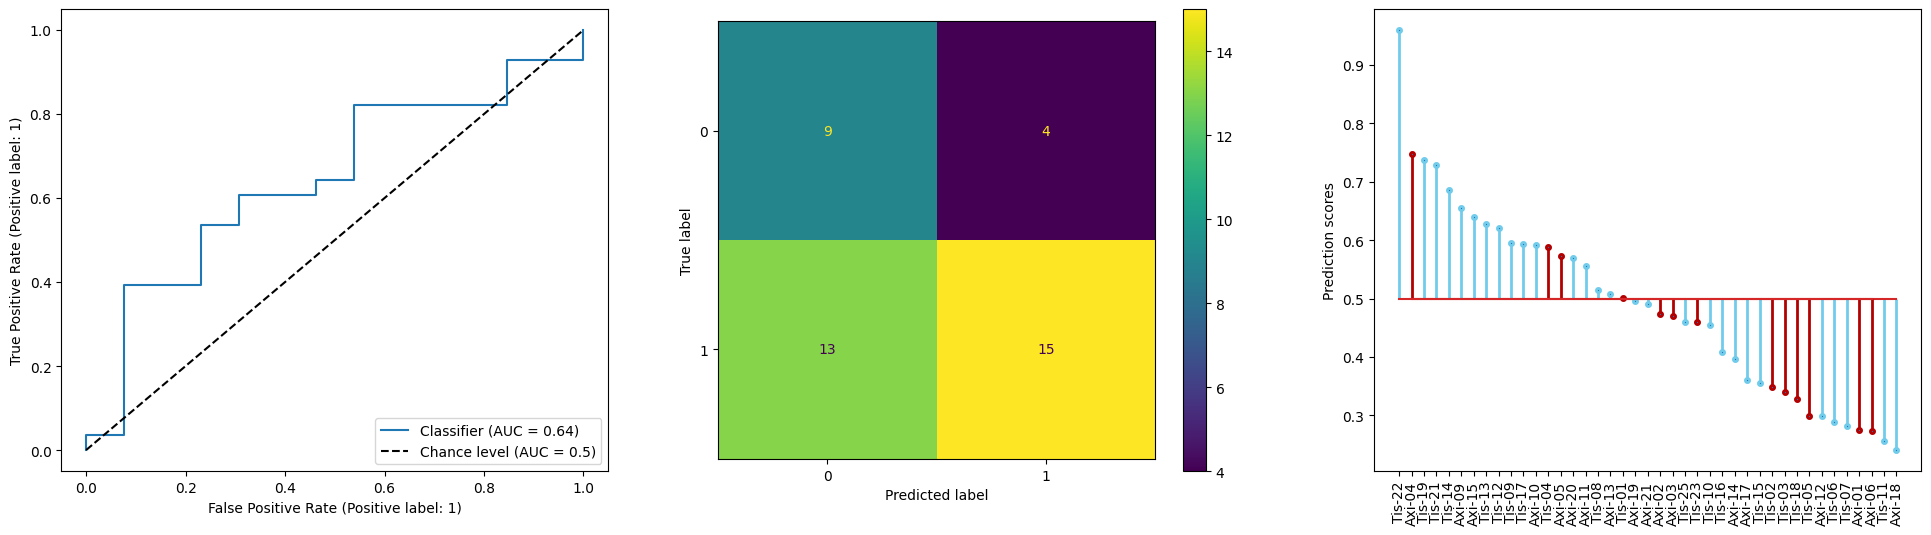

Cellular frequencies: test
R precision: 0.8
NR precision: 0.375
accuracy: 0.538


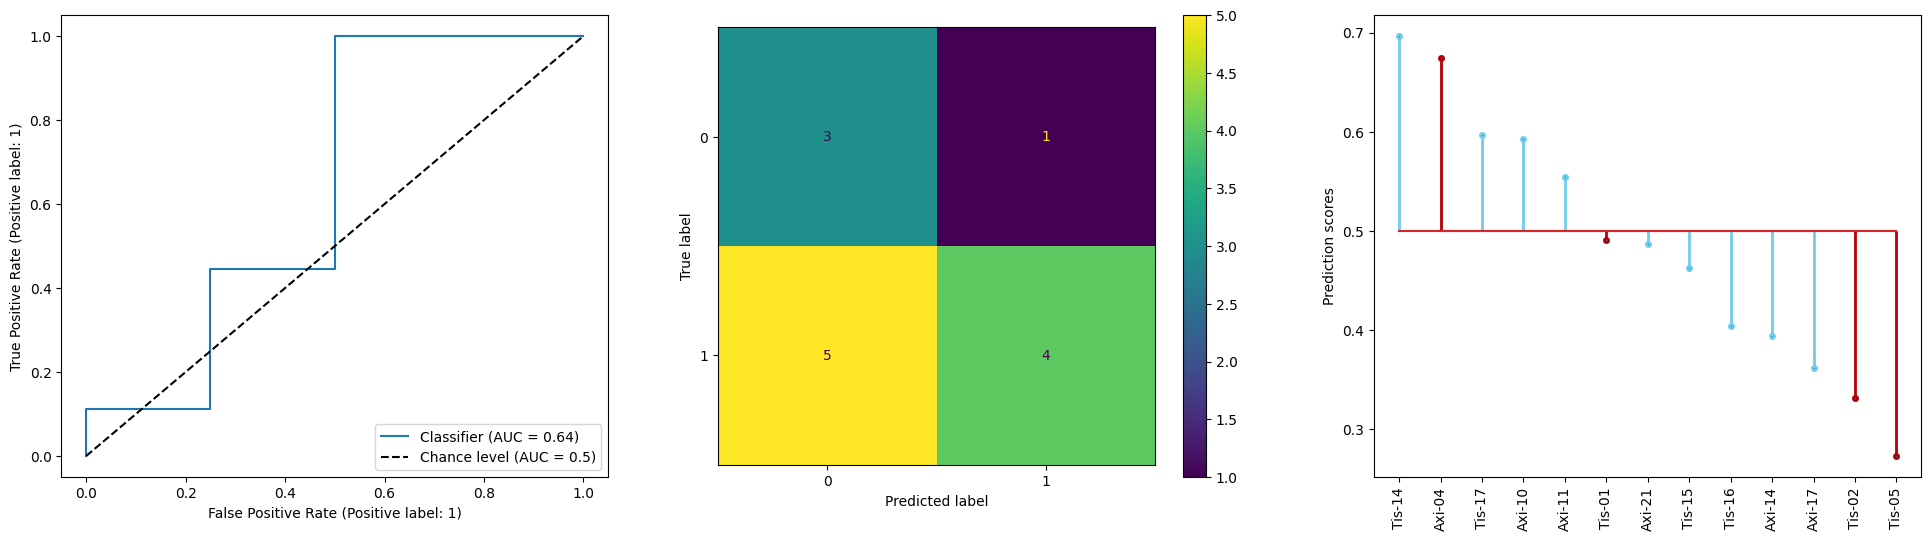

Myeloid pathways: loocv
R precision: 0.871
NR precision: 0.9
accuracy: 0.878


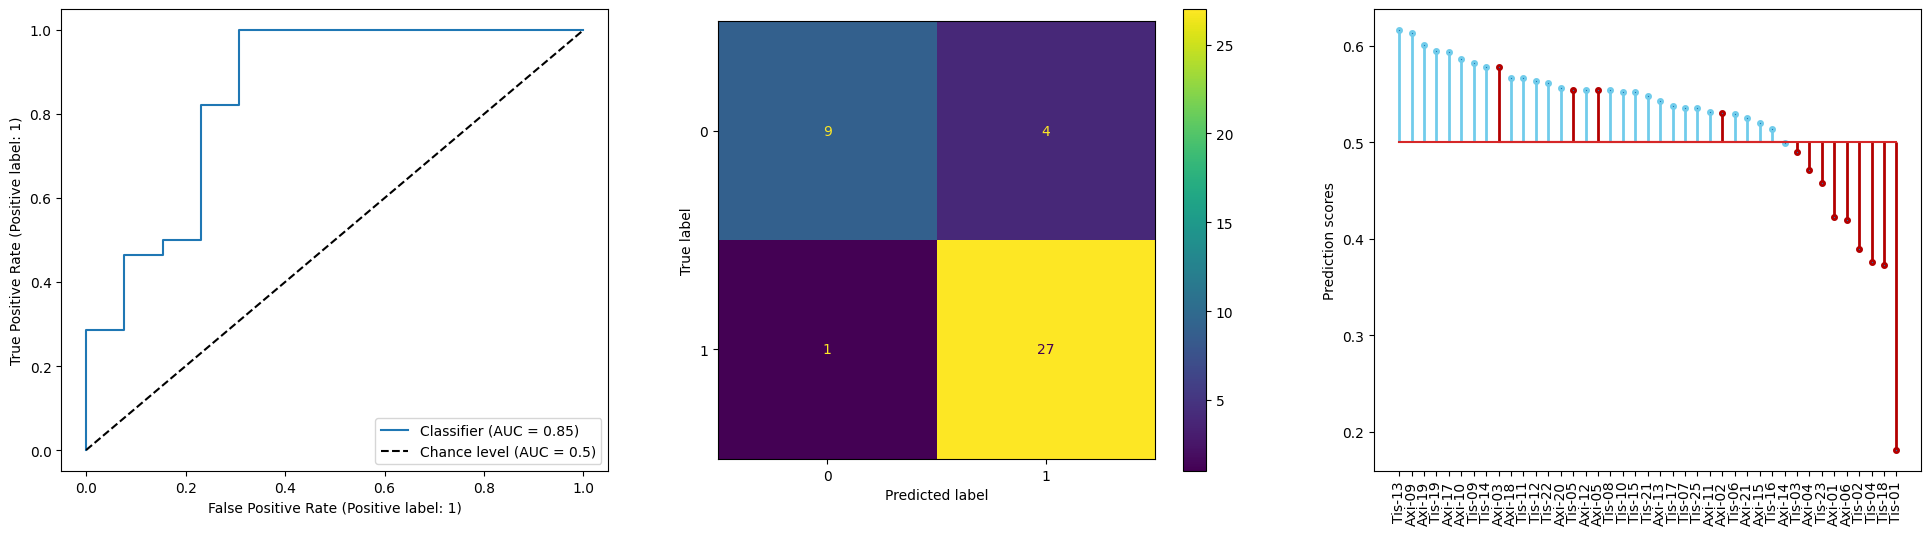

Myeloid pathways: test
R precision: 0.889
NR precision: 0.75
accuracy: 0.846


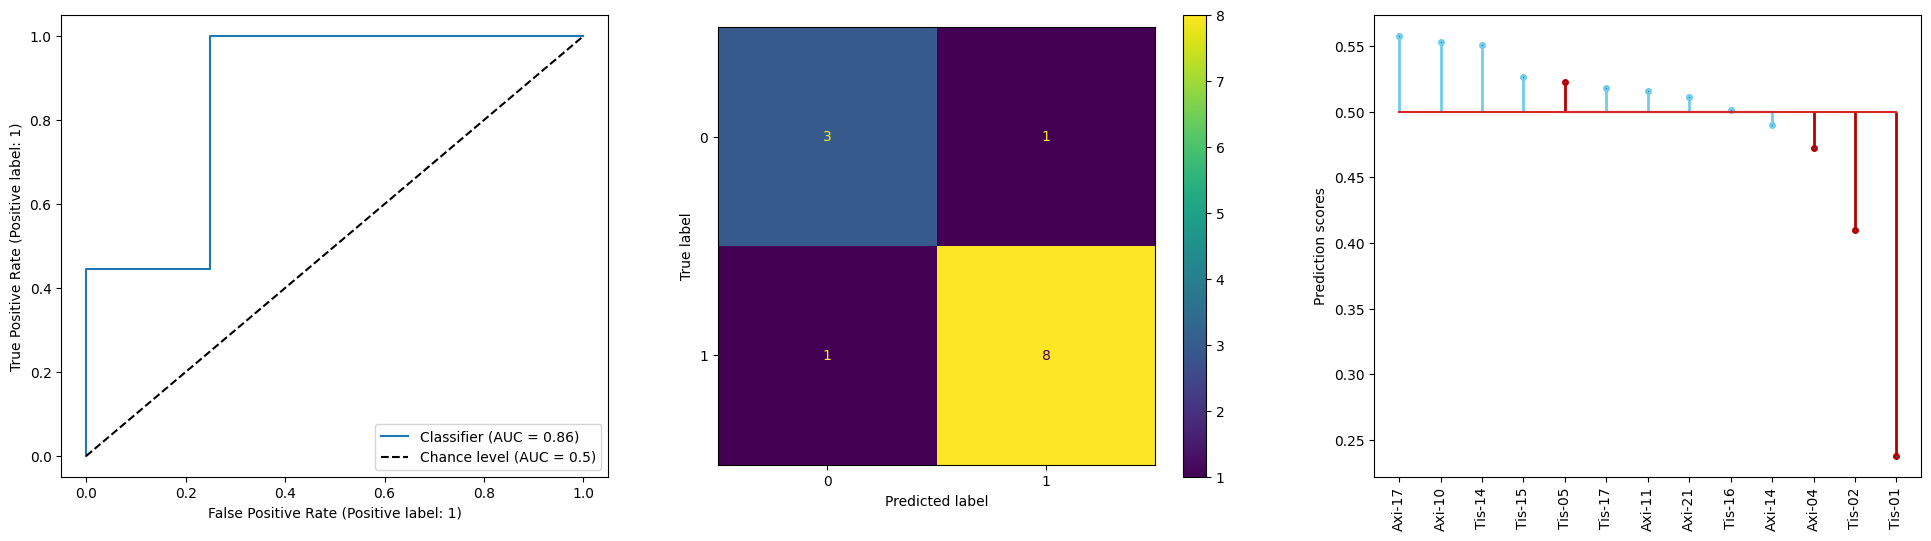

Combined: loocv
R precision: 0.926
NR precision: 0.786
accuracy: 0.878


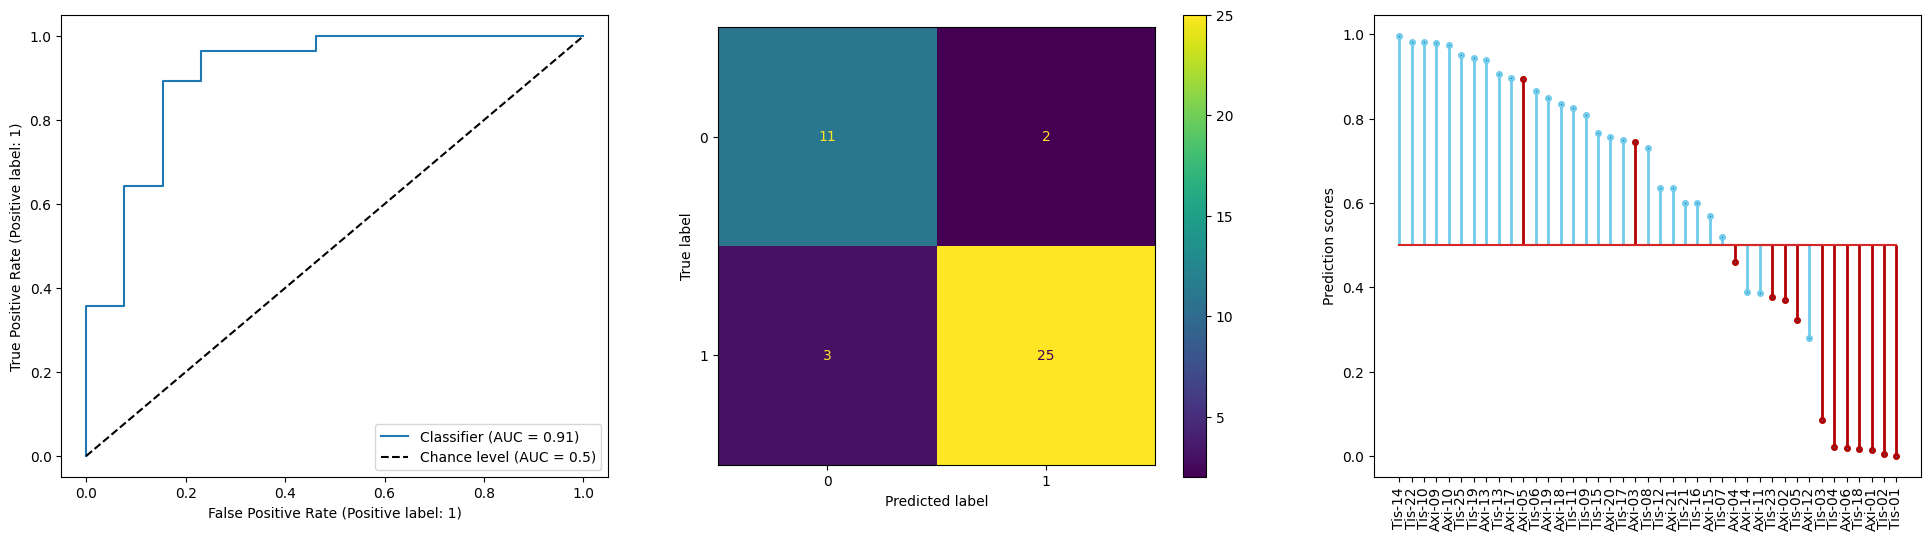

Combined: test
R precision: 1.0
NR precision: 0.667
accuracy: 0.846


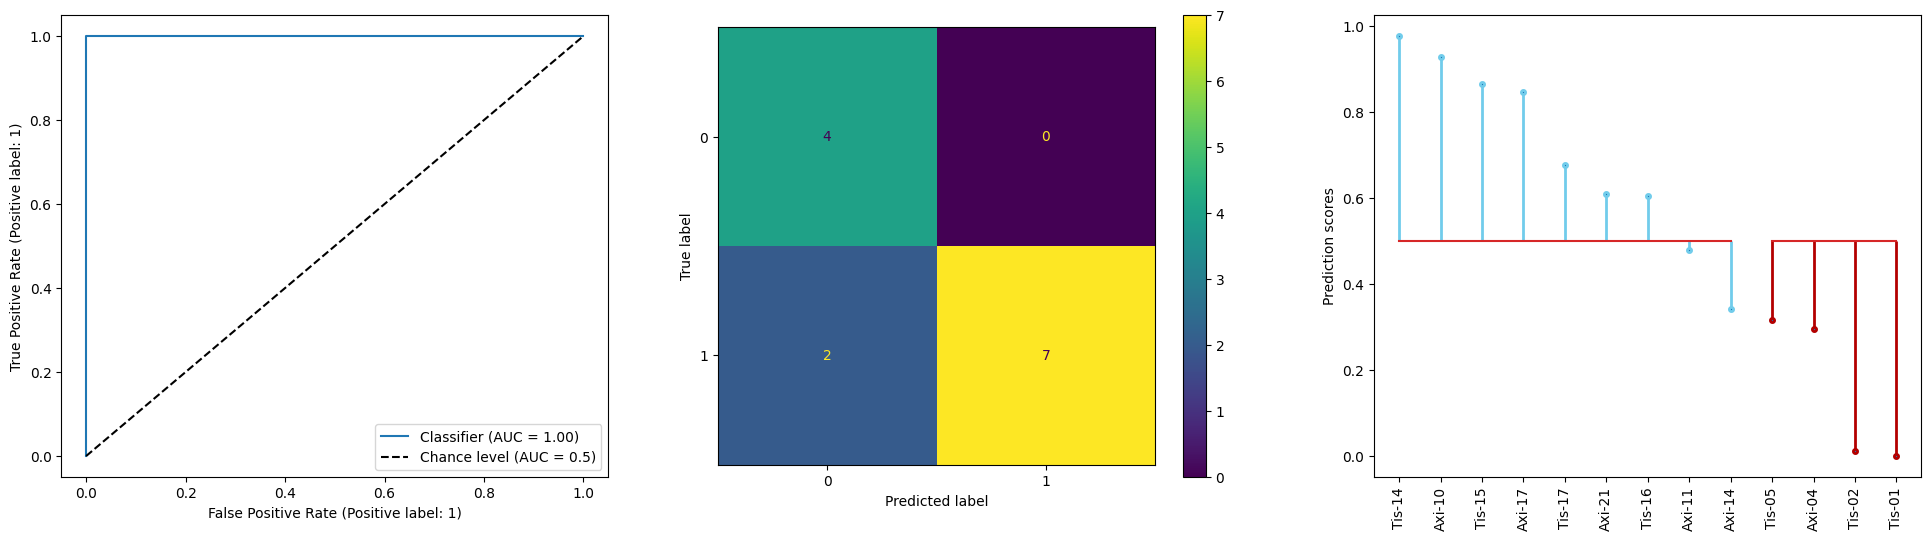

In [14]:
for exp_name, results in exps_dict.items():
    for eval_key in ['loocv', 'test']:
        y_true = results[eval_key]["y"].rename(index=patient_name_map)
        y_pred = np.array(results[eval_key]["y_pred"])
        y_proba =  np.array(results[eval_key]["y_proba"])
        
        print(f"{exp_name}: {eval_key}")
        print_metrics(y_true, y_pred)
        plot_ROC_PRauc_CM_stem(y_true, y_pred, y_proba)

## plot combined ROC curve

In [15]:
from sklearn.metrics import RocCurveDisplay

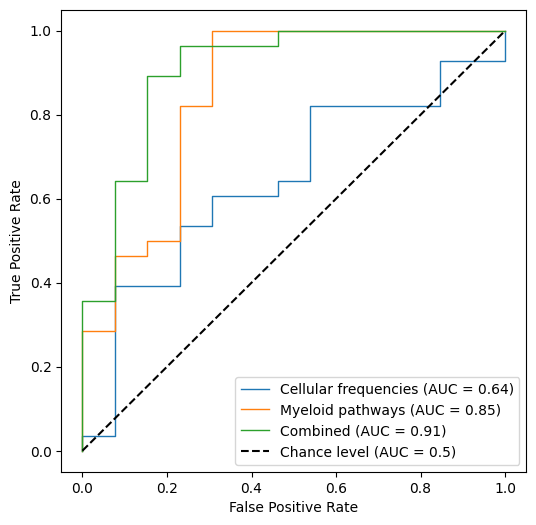

In [16]:

fig, ax = plt.subplots(figsize=(6, 6))
# for fold, (train, test) in enumerate(cv.split(X, y)):
for i, (exp_name, results) in enumerate(exps_dict.items()):
    y_true = results['loocv']["y"].rename(index=patient_name_map)
    y_proba =  np.array(results['loocv']["y_proba"])
    # exp_name = exp_name.replace('_results', '').replace('comp', 'Cellular frequencies').replace('_', ' ').replace('mye ', '').replace("pathways", "Myeloid pathways")
    viz = RocCurveDisplay.from_predictions(
        y_true,
        y_proba,
        name=f"{exp_name}",
        alpha=1,
        lw=1,
        ax=ax,
        plot_chance_level=(i == len(exps_dict)-1),
    )

    xlabel = "False Positive Rate"
    ylabel = "True Positive Rate"
    ax.set(xlabel=xlabel, ylabel=ylabel)

## orgenize dataset for export

In [24]:
full_df = pd.concat([comp_pathways_results["X"],
                     comp_pathways_results["y"],
                     comp_pathways_results["loocv"]["y_proba"]],
                    axis=1)
full_df = full_df.rename(columns={"response_3m": "label {1:R, 0:NR}", 0: "y_pred"}).rename(index=patient_name_map)
full_df.columns

Index(['HALLMARK_APICAL_JUNCTION-CD16 Mono', 'HALLMARK_APOPTOSIS-CD16 Mono',
       'HALLMARK_CHOLESTEROL_HOMEOSTASIS-CD16 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-CD14 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-CD16 Mono',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD14 Mono',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono', 'B', 'CD4.CM', 'CD4.EM',
       'CD4.Naive', 'CD8.CM', 'CD8.EM', 'CD8.naive', 'Cycling', 'MAIT',
       'NK.bright', 'NK.dim', 'Tregs', 'CD14 Mono', 'CD16 Mono', 'DCs',
       'Inter Mono', 'pDC', 'B_category', 'mon_ratio', 'CD4', 'CD8',
       'label {1:R, 0:NR}', 'y_pred'],
      dtype='object')

In [27]:
wanted_columns = ['label {1:R, 0:NR}', 'y_pred', "HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono", 'B_category', 'B', 'mon_ratio','CD4', 'CD8', 'CD8.EM', 'CD4.EM']
partial_df = full_df[wanted_columns]
partial_df.columns

Index(['label {1:R, 0:NR}', 'y_pred',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono', 'B_category', 'B',
       'mon_ratio', 'CD4', 'CD8', 'CD8.EM', 'CD4.EM'],
      dtype='object')

In [28]:
# full_df.to_csv(Path(data_dir_path, "all_fetures_prediction_labels.csv"))
# partial_df.to_csv(Path(data_dir_path, "partial_fetures_prediction_labels.csv"))